[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ee-ortiz/ISIS-4825_202510_IMAGENES_Y_VISION/blob/main/Laboratorio_07/Taller/MISIS4825_Laboratorio07_Taller.ipynb)

![image](https://drive.google.com/u/0/uc?id=15DUc09hFGqR8qcpYiN1OajRNaASmiL6d&export=download)

# Laboratorio 07 - Taller: Redes Neuronales Convolucionales

En este taller profundizaremos en el diseño, implementación y optimización de redes neuronales convolucionales (CNNs) para tareas de clasificación de imágenes. Utilizaremos el conjunto de datos **Covid-19 Chest X-Ray Images**, el cual contiene imágenes de radiografías de tórax de personas diagnosticadas con COVID-19 y personas sin la enfermedad.

El objetivo principal es construir y optimizar modelos de CNN propios que permitan distinguir entre las diferentes clases presentes en el dataset.


## Instrucciones del Taller

### 1. Diseño y Construcción de una Red Convolucional Propia

- **Arquitectura de la CNN:**  
  Diseñe una arquitectura de CNN personalizada utilizando Keras. Explique las decisiones tomadas en cada etapa, tales como:
  - Número y tipo de capas convolucionales.
  - Tamaño de los filtros y kernels.
  - Elección de las capas de pooling (MaxPooling2D, AveragePooling2D, etc.).
  - Funciones de activación utilizadas (por ejemplo, ReLU).
  - Implementación de técnicas de regularización (por ejemplo, Dropout) para prevenir el sobreajuste.
- **Preprocesamiento de Datos:**  
  Realice el preprocesamiento adecuado de los datos, como reescalado (normalización) y data augmentation, y divida el conjunto de datos en entrenamiento, validación y test.
- **Documentación:**  
  Justifique las decisiones de diseño y preprocesamiento, explicando cómo cada elección impacta el rendimiento del modelo.

### 2. Experimentación y Optimización del Modelo

- **Ajuste de Arquitectura y Hiperparámetros:**  
  Realice experimentos modificando la arquitectura base de su CNN. Algunas ideas incluyen:
  - Variar el número de capas convolucionales y neuronas en las capas densas.
  - Ajustar los parámetros de las capas de pooling.
  - Modificar la tasa de Dropout, la tasa de aprendizaje, y el tamaño del batch.
- **Evaluación de Resultados:**  
  Documente y analice los resultados obtenidos en cada experimento. Utilice métricas como precisión, recall, F1-score y la matriz de confusión para evaluar el desempeño.
- **Visualización:**  
  Genere gráficos que muestren la evolución de la precisión y la pérdida durante el entrenamiento, así como las matrices de confusión para comparar las distintas configuraciones.

### 3. Análisis y Discusión de Resultados

- **Comparación de Experimentos:**  
  Compare el rendimiento de su modelo base con las variantes experimentales. Analice y discuta:
  - ¿Qué impacto tiene la profundidad de la red y el número de filtros en la capacidad de aprendizaje?
  - ¿Cómo influyen las técnicas de regularización (por ejemplo, Dropout) en la capacidad de generalización del modelo?
  - ¿Qué mejoras adicionales se podrían implementar para optimizar aún más el rendimiento del modelo?
- **Reflexión:**  
  Plantee conclusiones y proponga futuras líneas de trabajo o posibles ajustes en la arquitectura que podrían mejorar la clasificación.


**Datos:** [Covid-19 Chest X-Ray Images](https://www.kaggle.com/datasets/sachinkumar413/cxr-2-classes)

In [54]:
import json
import os
import shutil

x_sixe, y_size = 128, 128

In [55]:
# Cargar credenciales desde kaggle.json
with open('./kaggle.json') as f:
    kaggle_credentials = json.load(f)

os.environ['KAGGLE_USERNAME'] = kaggle_credentials['username']
os.environ['KAGGLE_KEY'] = kaggle_credentials['key']

# Autenticar y descargar el dataset
from kaggle.api.kaggle_api_extended import KaggleApi
api = KaggleApi()
api.authenticate()
api.dataset_download_files('sachinkumar413/cxr-2-classes', path='data/cxr-2-classes', unzip=True)

# Eliminar carpeta redundante si existe
redundant_folder_path = 'data/cxr-2-classes/cxr-2-classes'
if os.path.exists(redundant_folder_path):
    shutil.rmtree(redundant_folder_path)

Dataset URL: https://www.kaggle.com/datasets/sachinkumar413/cxr-2-classes


Forma del array de la imagen cargada: (128, 128, 1)
Forma del array de la imagen cargada: (128, 128, 1)


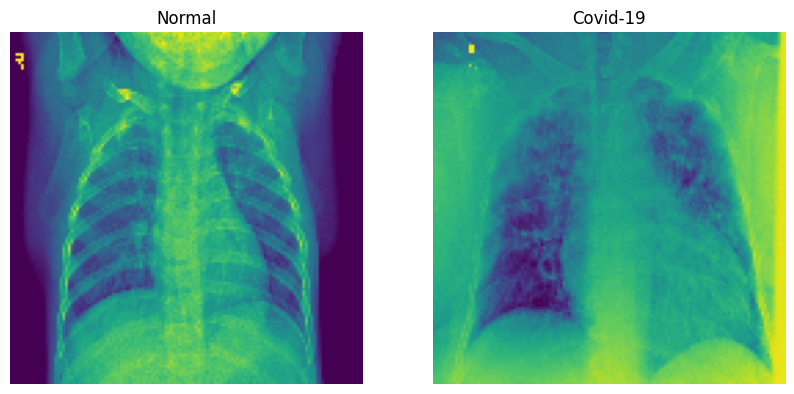

Total de imágenes: 1675
Número de imágenes por categoría:
Normal: 850
Covid-19: 825


In [64]:
import matplotlib.pyplot as plt
from tensorflow import keras
import os

# Directorio de datos y obtención de las categorías
data_dir = 'data/cxr-2-classes'
cxr_2_classes = os.listdir(data_dir)

# Visualización de una imagen de cada categoría
plt.figure(figsize=(10, 50))
for i, category in enumerate(cxr_2_classes):
    folder = os.path.join(data_dir, category)
    image_file = os.listdir(folder)[0]
    img_path = os.path.join(folder, image_file)
    img = keras.preprocessing.image.load_img(img_path, target_size=(128, 128), color_mode='grayscale')
    plt.subplot(int(len(cxr_2_classes)/2) + 1, 2, i+1)
    plt.title(category)
    plt.imshow(img)
    plt.axis('off')

plt.show()

# Análisis del tamaño y distribución de clases
image_count = {}
total_images = 0
for category in cxr_2_classes:
    folder = os.path.join(data_dir, category)
    count = len(os.listdir(folder))
    image_count[category] = count
    total_images += count

print(f"Total de imágenes: {total_images}")
print("Número de imágenes por categoría:")
for category, count in image_count.items():
    print(f"{category}: {count}")

In [58]:
import pandas as pd
from sklearn.model_selection import train_test_split
import os

# Recopilación de rutas y etiquetas
filepaths = [os.path.join(dp, f) for dp, dn, filenames in os.walk(data_dir)
             for f in filenames if os.path.splitext(f)[1].lower() in ['.png','.jpg','.jpeg']]
labels = [os.path.split(os.path.split(path)[0])[1] for path in filepaths]

# Crear DataFrame
data_df = pd.DataFrame({'filepath': filepaths, 'label': labels})

# Dividir en entrenamiento (70%), validación (20%) y test (10%)
train_df, test_val_df = train_test_split(data_df, test_size=0.3, random_state=13)
test_df, val_df = train_test_split(test_val_df, test_size=2/3, random_state=13)

print("Total de imágenes:", len(data_df))
print("Entrenamiento:", len(train_df))
print("Validación:", len(val_df))
print("Test:", len(test_df))

Total de imágenes: 1675
Entrenamiento: 1172
Validación: 336
Test: 167


In [65]:
from tensorflow import keras

# Generador para entrenamiento con data augmentation
train_datagen = keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    horizontal_flip=True,
    color_mode='grayscale'

)

# Generador para validación y test (solo reescala)
test_val_datagen = keras.preprocessing.image.ImageDataGenerator(rescale=1./255, color_mode='grayscale')

# Creación de generadores a partir de los DataFrames
train_gen = train_datagen.flow_from_dataframe(
    train_df, x_col='filepath', y_col='label',
    target_size=(x_sixe, y_size), batch_size=32
)
val_gen = test_val_datagen.flow_from_dataframe(
    val_df, x_col='filepath', y_col='label',
    target_size=(x_sixe, y_size), batch_size=32, shuffle=False
)
test_gen = test_val_datagen.flow_from_dataframe(
    test_df, x_col='filepath', y_col='label',
    target_size=(x_sixe, y_size), batch_size=32, shuffle=False
)

TypeError: ImageDataGenerator.__init__() got an unexpected keyword argument 'color_mode'

In [60]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# Construcción del modelo CNN
model = Sequential([
    # Primera capa convolucional: extrae características básicas
    Conv2D(16, (3, 3), activation='relu', input_shape=(x_sixe, y_size, 1)),
    MaxPooling2D((2, 2)),

    # Segunda capa convolucional: extrae características más complejas
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),

    # Aplanamiento para conectar con las capas densas
    Flatten(),
    Dense(16, activation='relu'),
    Dropout(0.2),
    Dense(len(cxr_2_classes), activation='softmax')  # Capa de salida para clasificación
])

# Resumen del modelo para verificar la arquitectura
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)               │ (None, 126, 126, 16)   │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 63, 63, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 61, 61, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 30, 30, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 28800)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 16)             │       460,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 2)              │            34 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 465,650 (1.78 MB)

 Trainable params: 465,650 (1.78 MB)

 Non-trainable params: 0 (0.00 B)

In [61]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [62]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

model_checkpoint = ModelCheckpoint('best_model.keras', save_best_only=True,
                                   monitor='val_loss', mode='min')
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='min')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, verbose=1, mode='min')

callbacks = [model_checkpoint, early_stopping, reduce_lr]

In [63]:
import tensorflow as tf

with tf.device('/device:GPU:0'):
    history = model.fit(
        train_gen,
        validation_data=val_gen,
        epochs=50,
        callbacks=callbacks
    )

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50


ValueError: Exception encountered when calling Sequential.call().

[1mInput 0 of layer "conv2d_8" is incompatible with the layer: expected axis -1 of input shape to have value 1, but received input with shape (None, 128, 128, 3)[0m

Arguments received by Sequential.call():
  • inputs=tf.Tensor(shape=(None, 128, 128, 3), dtype=float32)
  • training=True
  • mask=None

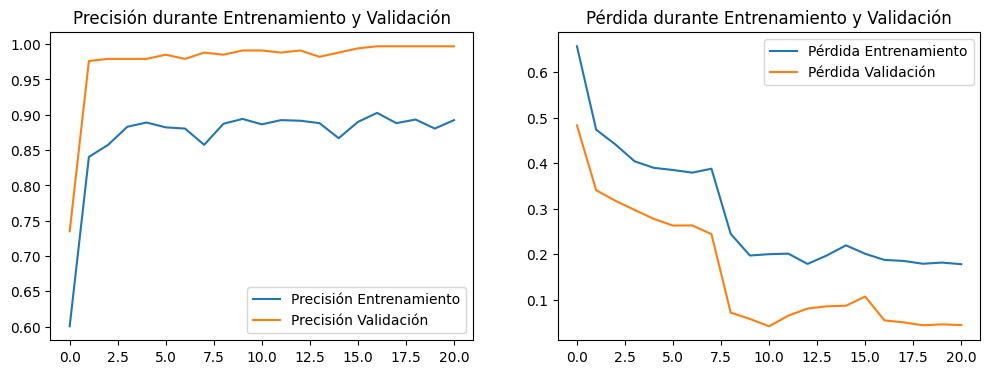

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step


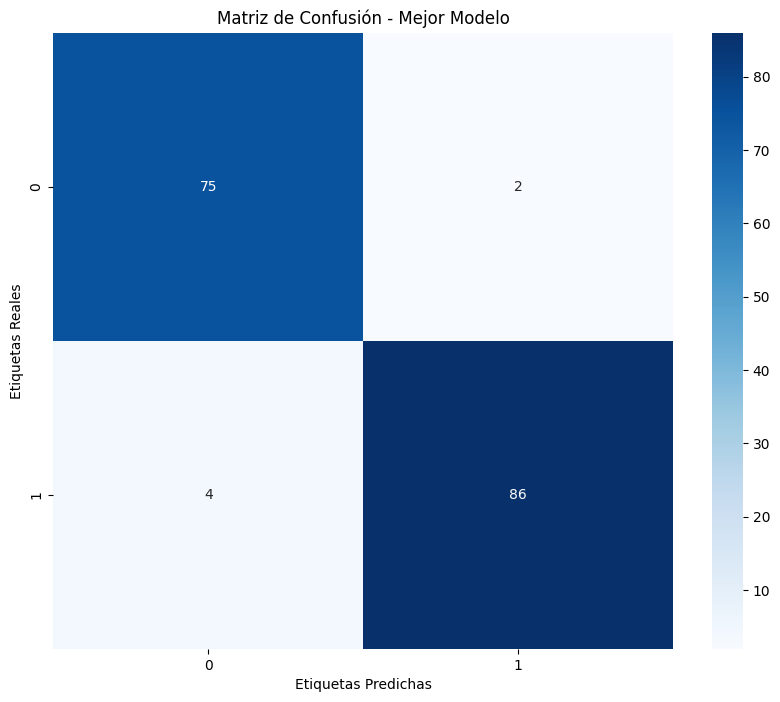

              precision    recall  f1-score   support

      Normal       0.95      0.97      0.96        77
    Covid-19       0.98      0.96      0.97        90

    accuracy                           0.96       167
   macro avg       0.96      0.96      0.96       167
weighted avg       0.96      0.96      0.96       167



In [21]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
from tensorflow.keras.models import load_model

# Visualización de la evolución del entrenamiento
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(acc))

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Precisión Entrenamiento')
plt.plot(epochs_range, val_acc, label='Precisión Validación')
plt.legend(loc='lower right')
plt.title('Precisión durante Entrenamiento y Validación')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Pérdida Entrenamiento')
plt.plot(epochs_range, val_loss, label='Pérdida Validación')
plt.legend(loc='upper right')
plt.title('Pérdida durante Entrenamiento y Validación')
plt.show()

# Cargar el modelo guardado con el mejor desempeño en validación
best_model = load_model('best_model.keras')

# Evaluar el modelo en el conjunto de test
test_gen.reset()
predicciones = best_model.predict(test_gen, verbose=1)
y_pred = np.argmax(predicciones, axis=1)
y_test = test_gen.classes

# Calcular y mostrar la matriz de confusión y el reporte de clasificación
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap=plt.cm.Blues)
plt.title('Matriz de Confusión - Mejor Modelo')
plt.ylabel('Etiquetas Reales')
plt.xlabel('Etiquetas Predichas')
plt.show()

print(classification_report(y_test, y_pred, target_names=cxr_2_classes, zero_division=0))